# Studying the correlation between drug-induced transcriptomic response and known targets

Data used (generated in the previous notebook):
- target_vectors.tsv (vectors representing the known targets of each drug)
- transcriptional_response_vectors.tsv (vectors representing the DEG induced by each drug)

In both matrices, the rows are chemicals and the columns are genes. The order of rows/columns is the same in both.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from scipy.stats import linregress
from scipy.stats import pearsonr

import getpass
import sys
import time
from tqdm import tqdm, tqdm_notebook
import string
import warnings
warnings.filterwarnings('ignore')

from utils import (get_pearson_corr, 
                     get_cosine_correlation, 
                     get_jaccard_correlation,
                     get_pearson_corr_permutation, 
                     get_cosine_corr_permutation, 
                     get_jaccard_corr_permutation,
                     get_similarity,
                     get_similarity_permutation,
                     get_nonzero_similarity,
                     get_nonzero_similarity_permutation)

In [2]:
getpass.getuser()

'chloehart'

In [3]:
sys.version

'3.8.11 (default, Aug  6 2021, 08:56:27) \n[Clang 10.0.0 ]'

In [4]:
time.asctime()

'Sat Dec 17 08:39:08 2022'

In [5]:
databases = ['ChemPert', 'ChemPert(Pathway_dbs)', 'ChemPert(Topological_level_3)']

## Load drug-induced transcriptomic response 

In [6]:
#Get transcript data frame for each database
transcript_df = {}
for database in tqdm(databases):
    transcriptomic_responses_df = pd.read_csv(
    '../data/Transcriptional_data_frames/transcriptional_response_vectors.tsv',
    sep='\t',
    index_col=0,
    )
    transcriptomic_responses_df.head(4)
    transcriptomic_responses_df.shape
    transcript_df[database] = transcriptomic_responses_df.copy()

100%|█████████████████████████████████████████████| 3/3 [00:02<00:00,  1.13it/s]


## Load the known targets for each drug

In [7]:
#Get target data frame for each database
target_df = {}
for database in tqdm(databases):
    if database == 'ChemPert':
        targets_df = pd.read_csv(
            '../data/target_data_frames/target_vectors_' + database + '.tsv',
            sep='\t',
            index_col=0,
        )
    else:
        targets_df = pd.read_csv(
            '../data/target_data_frames/target_vectors_' + database + '.csv',
            sep=',',
            index_col=0,
        )
        targets_df = targets_df.drop(list(set(targets_df.columns) \
                                      - set(transcript_df[database].columns)), axis=1)
        targets_df.to_csv('../data/target_data_frames/target_vectors_' + database + '.csv')
    target_df[database] = targets_df.copy()

100%|█████████████████████████████████████████████| 3/3 [00:06<00:00,  2.01s/it]


In [8]:
for database in tqdm(databases):
    assert list(target_df[database].columns) == list(transcript_df[database].columns)
    assert list(target_df[database].index) == list(transcript_df[database].index)
    

100%|███████████████████████████████████████████| 3/3 [00:00<00:00, 1120.67it/s]


# Get number of nonzero values in the target data frames

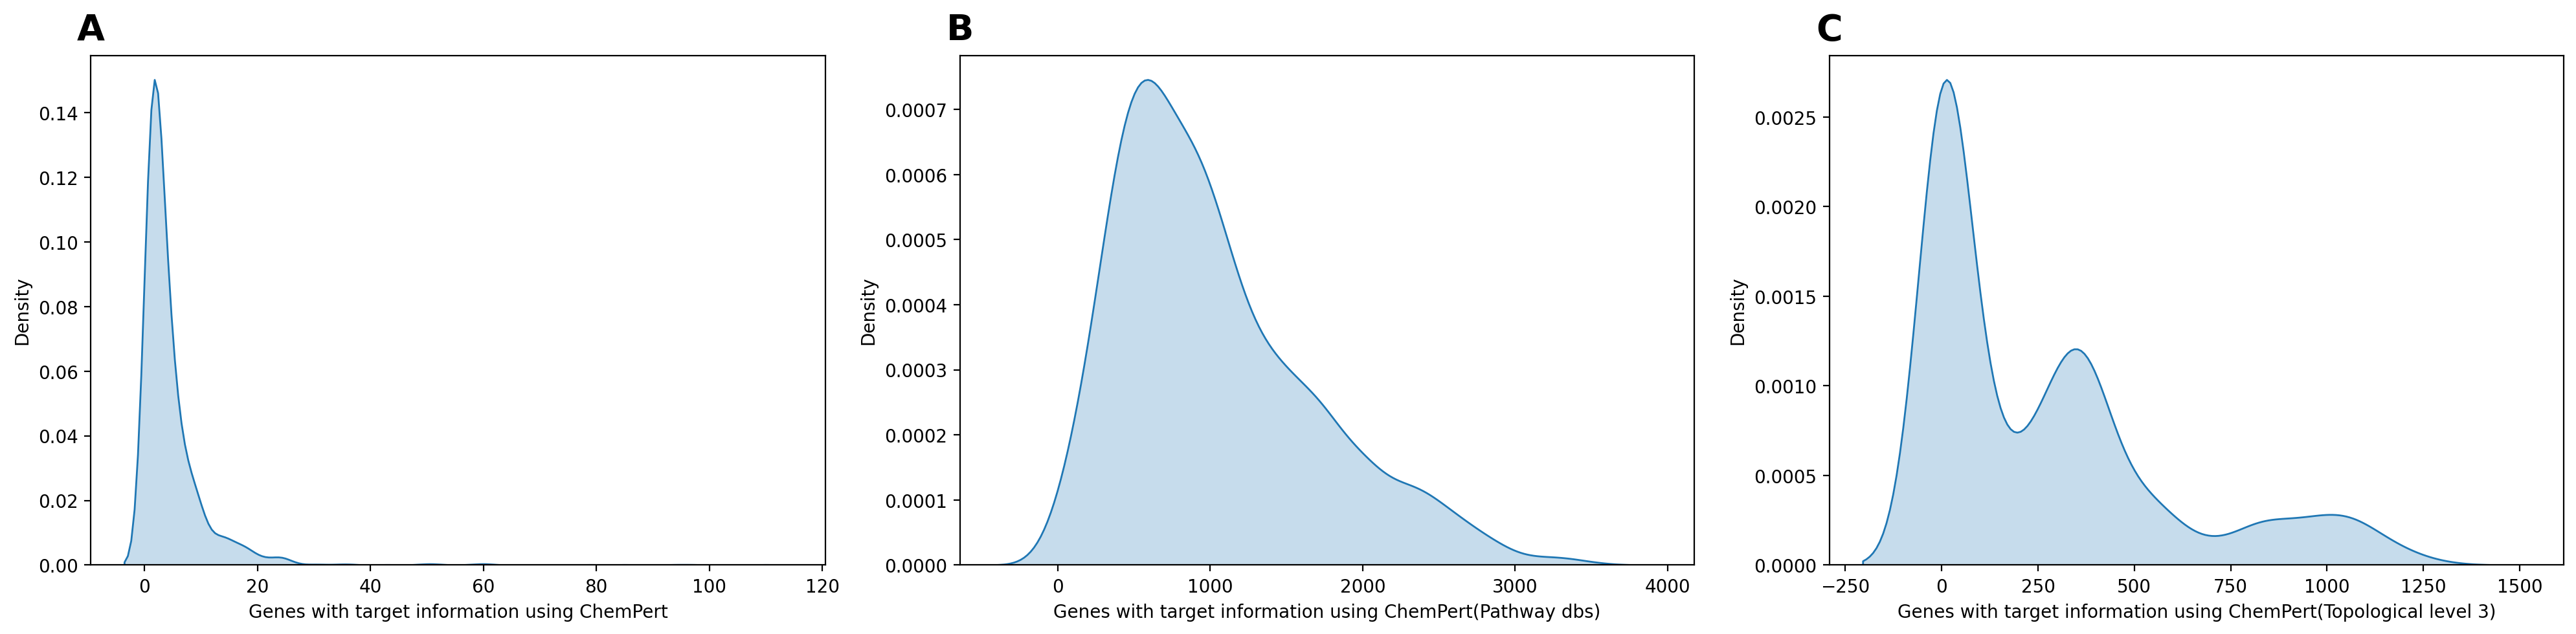

In [9]:
plt.figure(dpi=200, figsize = (20,5))

for i,database in enumerate(databases):
    #Set initial variables
    num_targets = []

    
    #Get number of nonzero targets
    for drug in target_df[database].index.values:
        num_targets.append(len(np.nonzero(list(target_df[database].loc[drug]))[0]))

    #Create plot
    plt.subplot(1, len(databases), i+1)
    sns.kdeplot(num_targets, shade=True)
    plt.xlabel('Genes with target information using ' + database.replace('_', ' '))
    plt.text(0, 1.05, string.ascii_uppercase[i],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)

# Show plot
plt.tight_layout()
plt.savefig('../figures/Supplementary_figure_3.png', bbox_inches='tight')
plt.show()
        

# Calculate Correlation Metrics for each drug

In [10]:
from numpy import dot
from numpy.linalg import norm
from scipy.spatial.distance import jaccard
from matplotlib.lines import Line2D

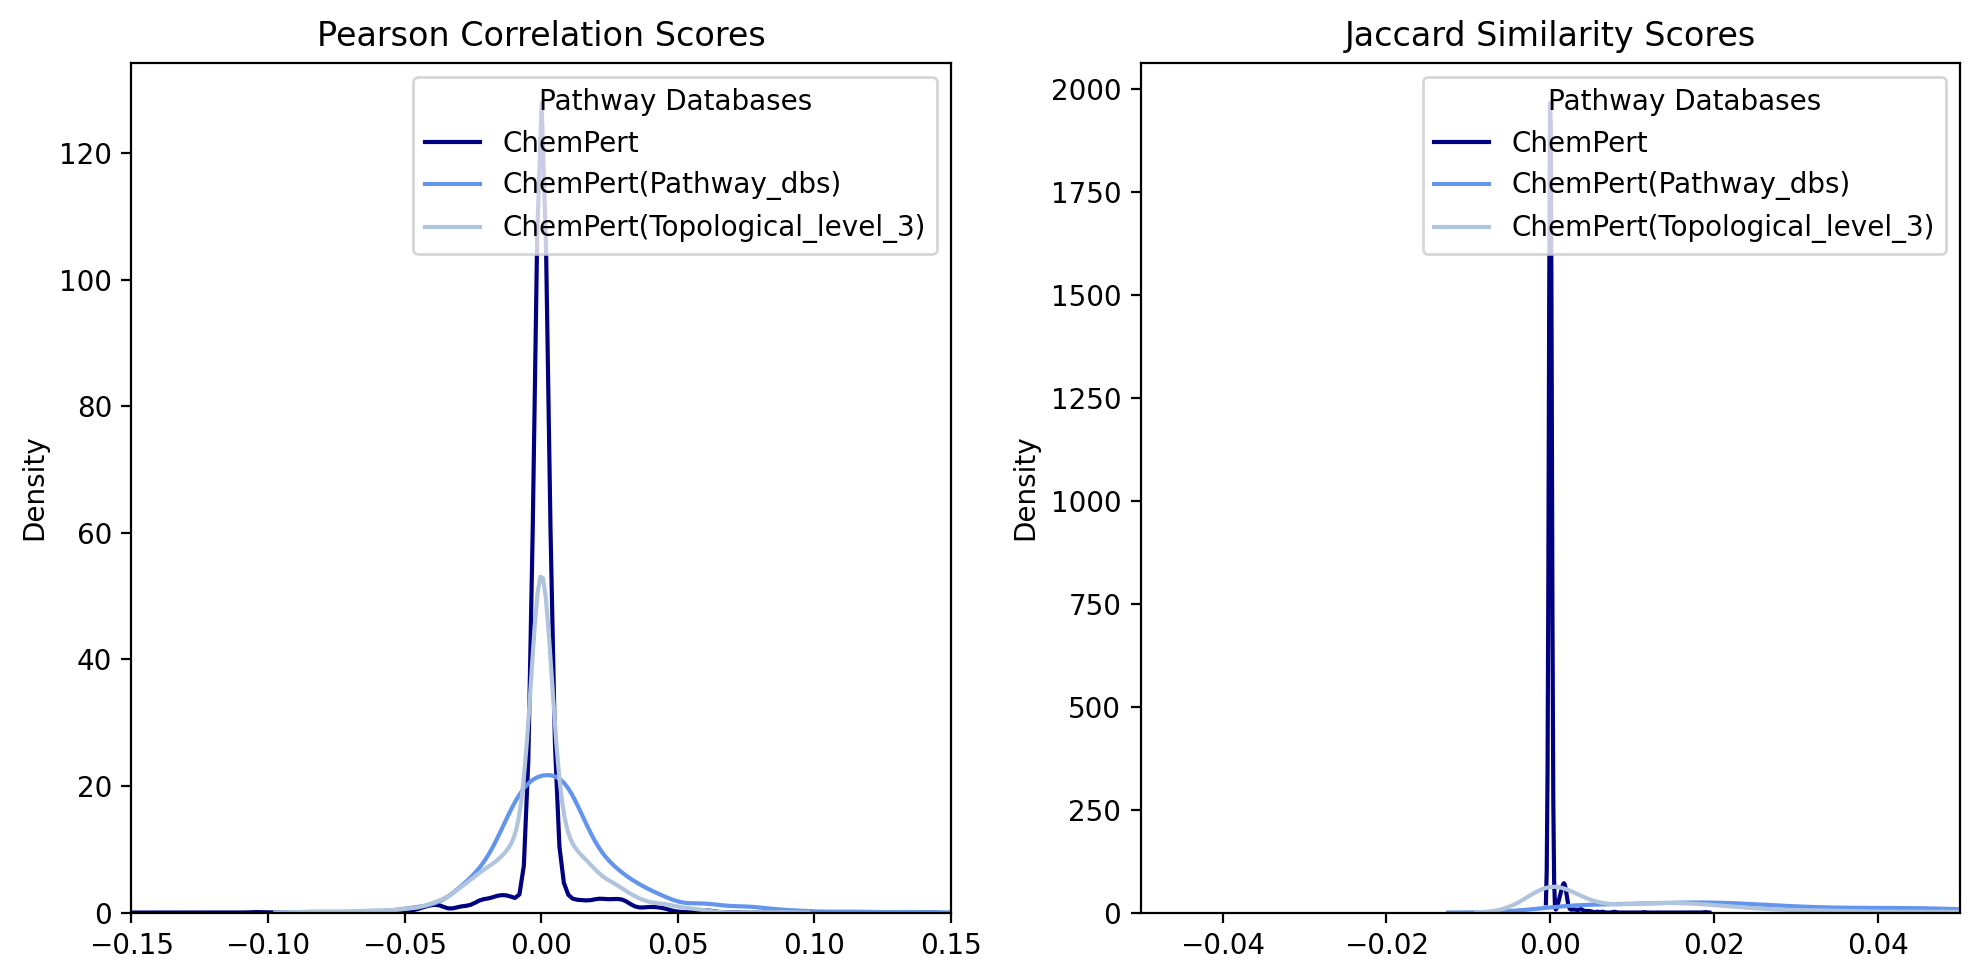

In [11]:
#Set initial variables
pearson_corr_df = {}
colors = ['navy', 'cornflowerblue', 'lightsteelblue','red', 'yellowgreen', 'royalblue', 'lightpink','gold', 'black']
cosine_corr_df = {}
jaccard_corr_df = {}

#Graph pearson correlation values for each database
plt.figure(figsize=(10,5), dpi =200)
for i,database in enumerate(databases):
    #Get pearson correlation values
    pearson_corr_df[database] = get_pearson_corr(target_matrix=target_df[database], \
                                                transcriptomic_matrix=transcript_df[database])
    
    #Plot Pearson correlation values
    plt.subplot(1,2,1)
    sns.distplot(pearson_corr_df[database].values, color=colors[i], label=database, hist=False)
    plt.xlim([-.15, .15])
    plt.legend(title="Pathway Databases", loc='upper right')
    plt.title('Pearson Correlation Scores')

    #Get Jaccard Similarity values
    jaccard_corr_df[database] = get_jaccard_correlation(
        target_matrix=target_df[database], 
        transcriptomic_matrix=transcript_df[database]
    )
    
    #Plot Jaccard Similarity values
    plt.subplot(1,2,2)
    sns.distplot(np.array(jaccard_corr_df[database].values), color=colors[i], label=database, hist=False)
    plt.xlim([-.15, .15])
    plt.legend(title="Pathway Databases", loc='upper right')
    plt.xlim([-.05,.05])
    plt.title('Jaccard Similarity Scores')

#Show plot
plt.tight_layout()
plt.show()


# Get Pearson Correlation for Drugs with more than 10 targets

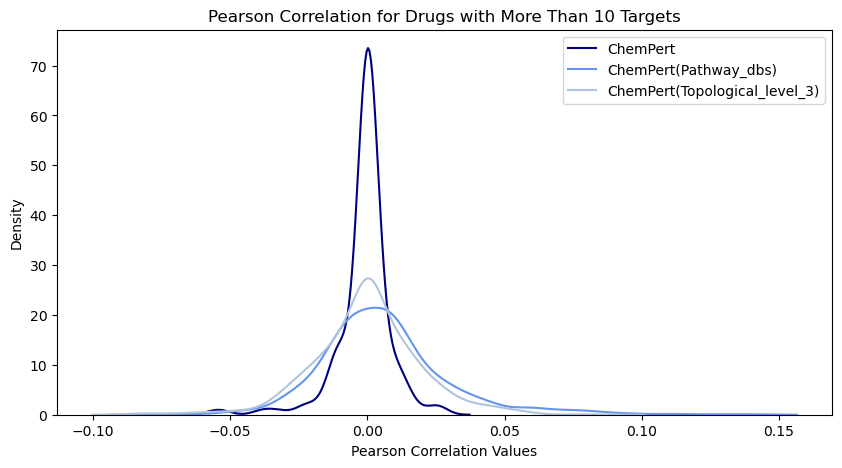

,KS test P-value,Mean Pearson Correlation for Drugs with at least 10 Targets,Mean Pearson Correlation for All Drugs
ChemPert,5.985235e-06,-0.001109,0.000399
ChemPert(Pathway_dbs),1.000000e+00,0.005995,0.005963
ChemPert(Topological_level_3),4.543674e-13,-0.000120,0.000085


In [12]:
# Check drugs with more than 10 targets and see if they have a higher corrrelation than the rest
plt.figure(figsize=(10,5))
stat_df = pd.DataFrame(columns=['KS test P-value', 'Mean Pearson Correlation for Drugs with at least 10 Targets',\
                             'Mean Pearson Correlation for All Drugs'])
for i,database in enumerate(databases):
    #Set initial variables
    corr_many_targets = []

    #Get drugs with more than 10 targets
    for drug in target_df[database].index.values:
        if np.count_nonzero(target_df[database].loc[drug]) > 10:
            corr_many_targets.append(pearson_corr_df[database].loc[drug, 'pearson_correlation'])


    #Plot the pearson correlation values for drugs with more than 10 targets
    sns.distplot(corr_many_targets, color=colors[i], label=database, hist=False)

    #Print P-value determining whether all drugs and drugs with more than 10 targets
    #come from the same distribution
    stat_1 = stats.ks_2samp(corr_many_targets, np.squeeze(pearson_corr_df[database].values))[1]
    stat_2 = np.nansum(corr_many_targets)/len(corr_many_targets)
    stat_3 = np.nansum(np.squeeze(pearson_corr_df[database].values))/len(np.squeeze(pearson_corr_df[database].values))
    stat_df.loc[database] = [stat_1, stat_2, stat_3]

# Show plot
plt.title("Pearson Correlation for Drugs with More Than 10 Targets")
plt.xlabel('Pearson Correlation Values')
plt.legend()
plt.show()
stat_df.head(len(databases))

# Get Pearson Correlation for 50 drugs with the most DEGs

100%|███████████████████████████████████████| 1000/1000 [01:03<00:00, 15.69it/s]


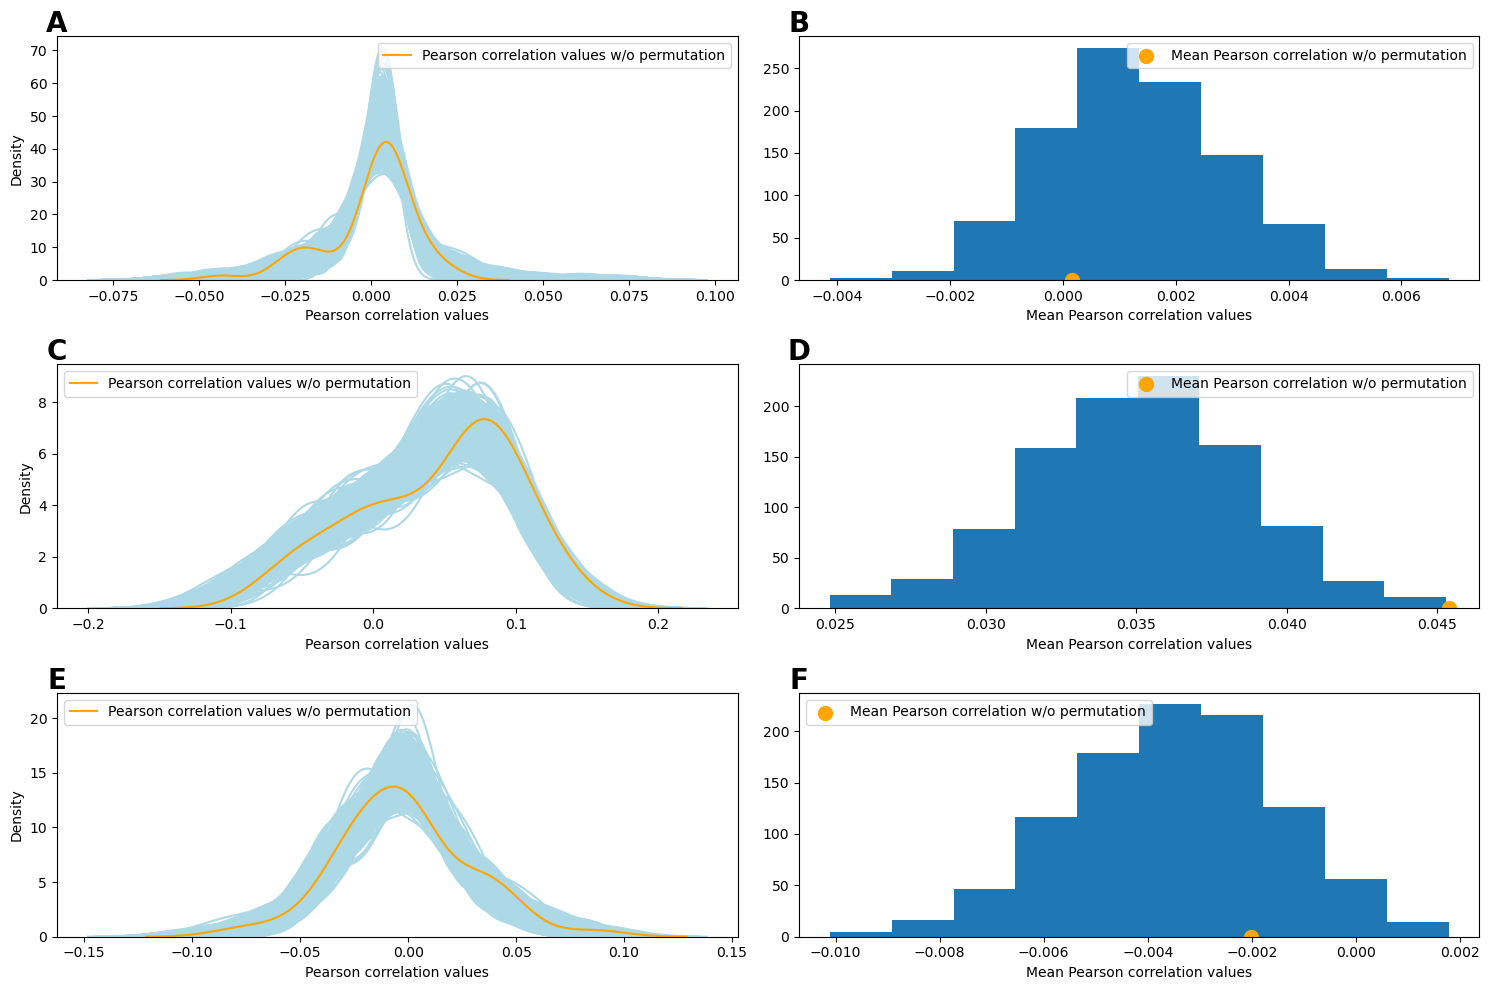

In [13]:
# Check the top 50 drugs with most DEG (Differentially expressed genes) and see 
#if they have a higher correlation than the rest
stat_df = pd.DataFrame(columns=['KS test P-value', 'Mean pearson Correlation for 50 Drugs with most DEGs',\
                             'Mean pearson Correlation for All Drugs'])
#Set initial variables
current_DEG_corr_df = {}
DEG_corr_df = {}
plt.figure().set_size_inches(15,10)
p_values = []
DEG_drug_trancriptomics = {}
DEG_drug_targets = {}

# Get correaltion scores for each database
for j,database in enumerate(databases):
    num_nonzero_vals = {}
    permutation_means = []
    num_compounds = 50
    num_permutations = 1000

    #Get number of DEGs for each drug
    for drug in transcript_df[database].index.values:
        num_nonzero_vals[drug] = np.count_nonzero(transcript_df[database].loc[drug])

    #Get 50 drugs with the most DEGs
    DEG_drugs = [x for _,x in sorted(zip(num_nonzero_vals.values(), num_nonzero_vals.keys()), reverse=True)]
    DEG_corr_df[database] = pearson_corr_df[database].filter(items = DEG_drugs[:50], axis=0)
    corr_DEG_drugs = [pearson_corr_df[database].loc[drug, 'pearson_correlation'] for drug in DEG_drugs[:50]]
    DEG_drug_targets[database] = target_df[database].filter(items = DEG_drugs[:50], axis=0)
    DEG_drug_trancriptomics[database] = transcript_df[database].filter(items = DEG_drugs[:50], axis=0)
    
    #calculate pearson correlation for 100 different permutations
    plt.subplot(len(databases), 2, 2*j+1)
    for i in tqdm(range(num_permutations)):
        current_target_df = DEG_drug_targets[database].copy()
        current_transcriptomic_df = DEG_drug_trancriptomics[database].copy()
        current_transcriptomic_df = current_transcriptomic_df.sample(frac=1)
        current_DEG_corr_df[database] = get_pearson_corr_permutation(target_matrix=current_target_df, \
                                                   transcriptomic_matrix=current_transcriptomic_df)
        permutation_means.append(np.nansum(current_DEG_corr_df[database]['pearson_correlation'])/num_compounds)
        sns.distplot(current_DEG_corr_df[database].values, hist=False, color='lightblue')
        
    #Plot pearson correlation scores for the permutations
    sns.distplot(DEG_corr_df[database].values, hist=False, color='orange', label = "Pearson correlation values w/o permutation")
    plt.legend()
    plt.text(0, 1.05, string.ascii_uppercase[2*j],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    plt.xlabel('Pearson correlation values')
        
    
    #Plot the mean pearson correlation scores for the permutations
    plt.subplot(len(databases), 2, 2*j+2)
    original_mean = np.nansum(DEG_corr_df[database]['pearson_correlation'])/num_compounds
    plt.hist(permutation_means, zorder=0)
    plt.scatter(original_mean, .2, s = 100, \
                label = 'Mean Pearson correlation w/o permutation', color = 'orange')
    plt.xlabel('Mean Pearson correlation values')
    plt.legend()
    plt.text(0, 1.05, string.ascii_uppercase[2*j+1],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    plt.tight_layout()

    #Get the permutation test p-value (based on the means)
    p_value = (len([x for x in permutation_means if x >= original_mean])+1)/num_permutations
    p_values.append(p_value)

plt.tight_layout()
plt.show()


In [14]:
#Set initial variables
ks_values = []
stat_df = pd.DataFrame(columns = ['Permutation Test P-value', 'KS Test P-value'])

#Pick random permutation test and do the KS test with the original pearson correlation scores
for i,database in enumerate(databases):
    ks_values.append(stats.ks_2samp(np.squeeze(current_DEG_corr_df[database].values), 
                                                   np.squeeze(DEG_corr_df[database].values))[1])
    stat_df.loc[database] = [p_values[i], ks_values[i]]
    
stat_df.head(len(database))

,Permutation Test P-value,KS Test P-value
ChemPert,0.761,0.869262
ChemPert(Pathway_dbs),0.001,0.548685
ChemPert(Topological_level_3),0.230,0.869262


# Permutate original targets and original perturbations and re-calculate correlations

In [15]:
# Permutate and apply function (x100 times)

### Permutate pairs and apply pearson correlation

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

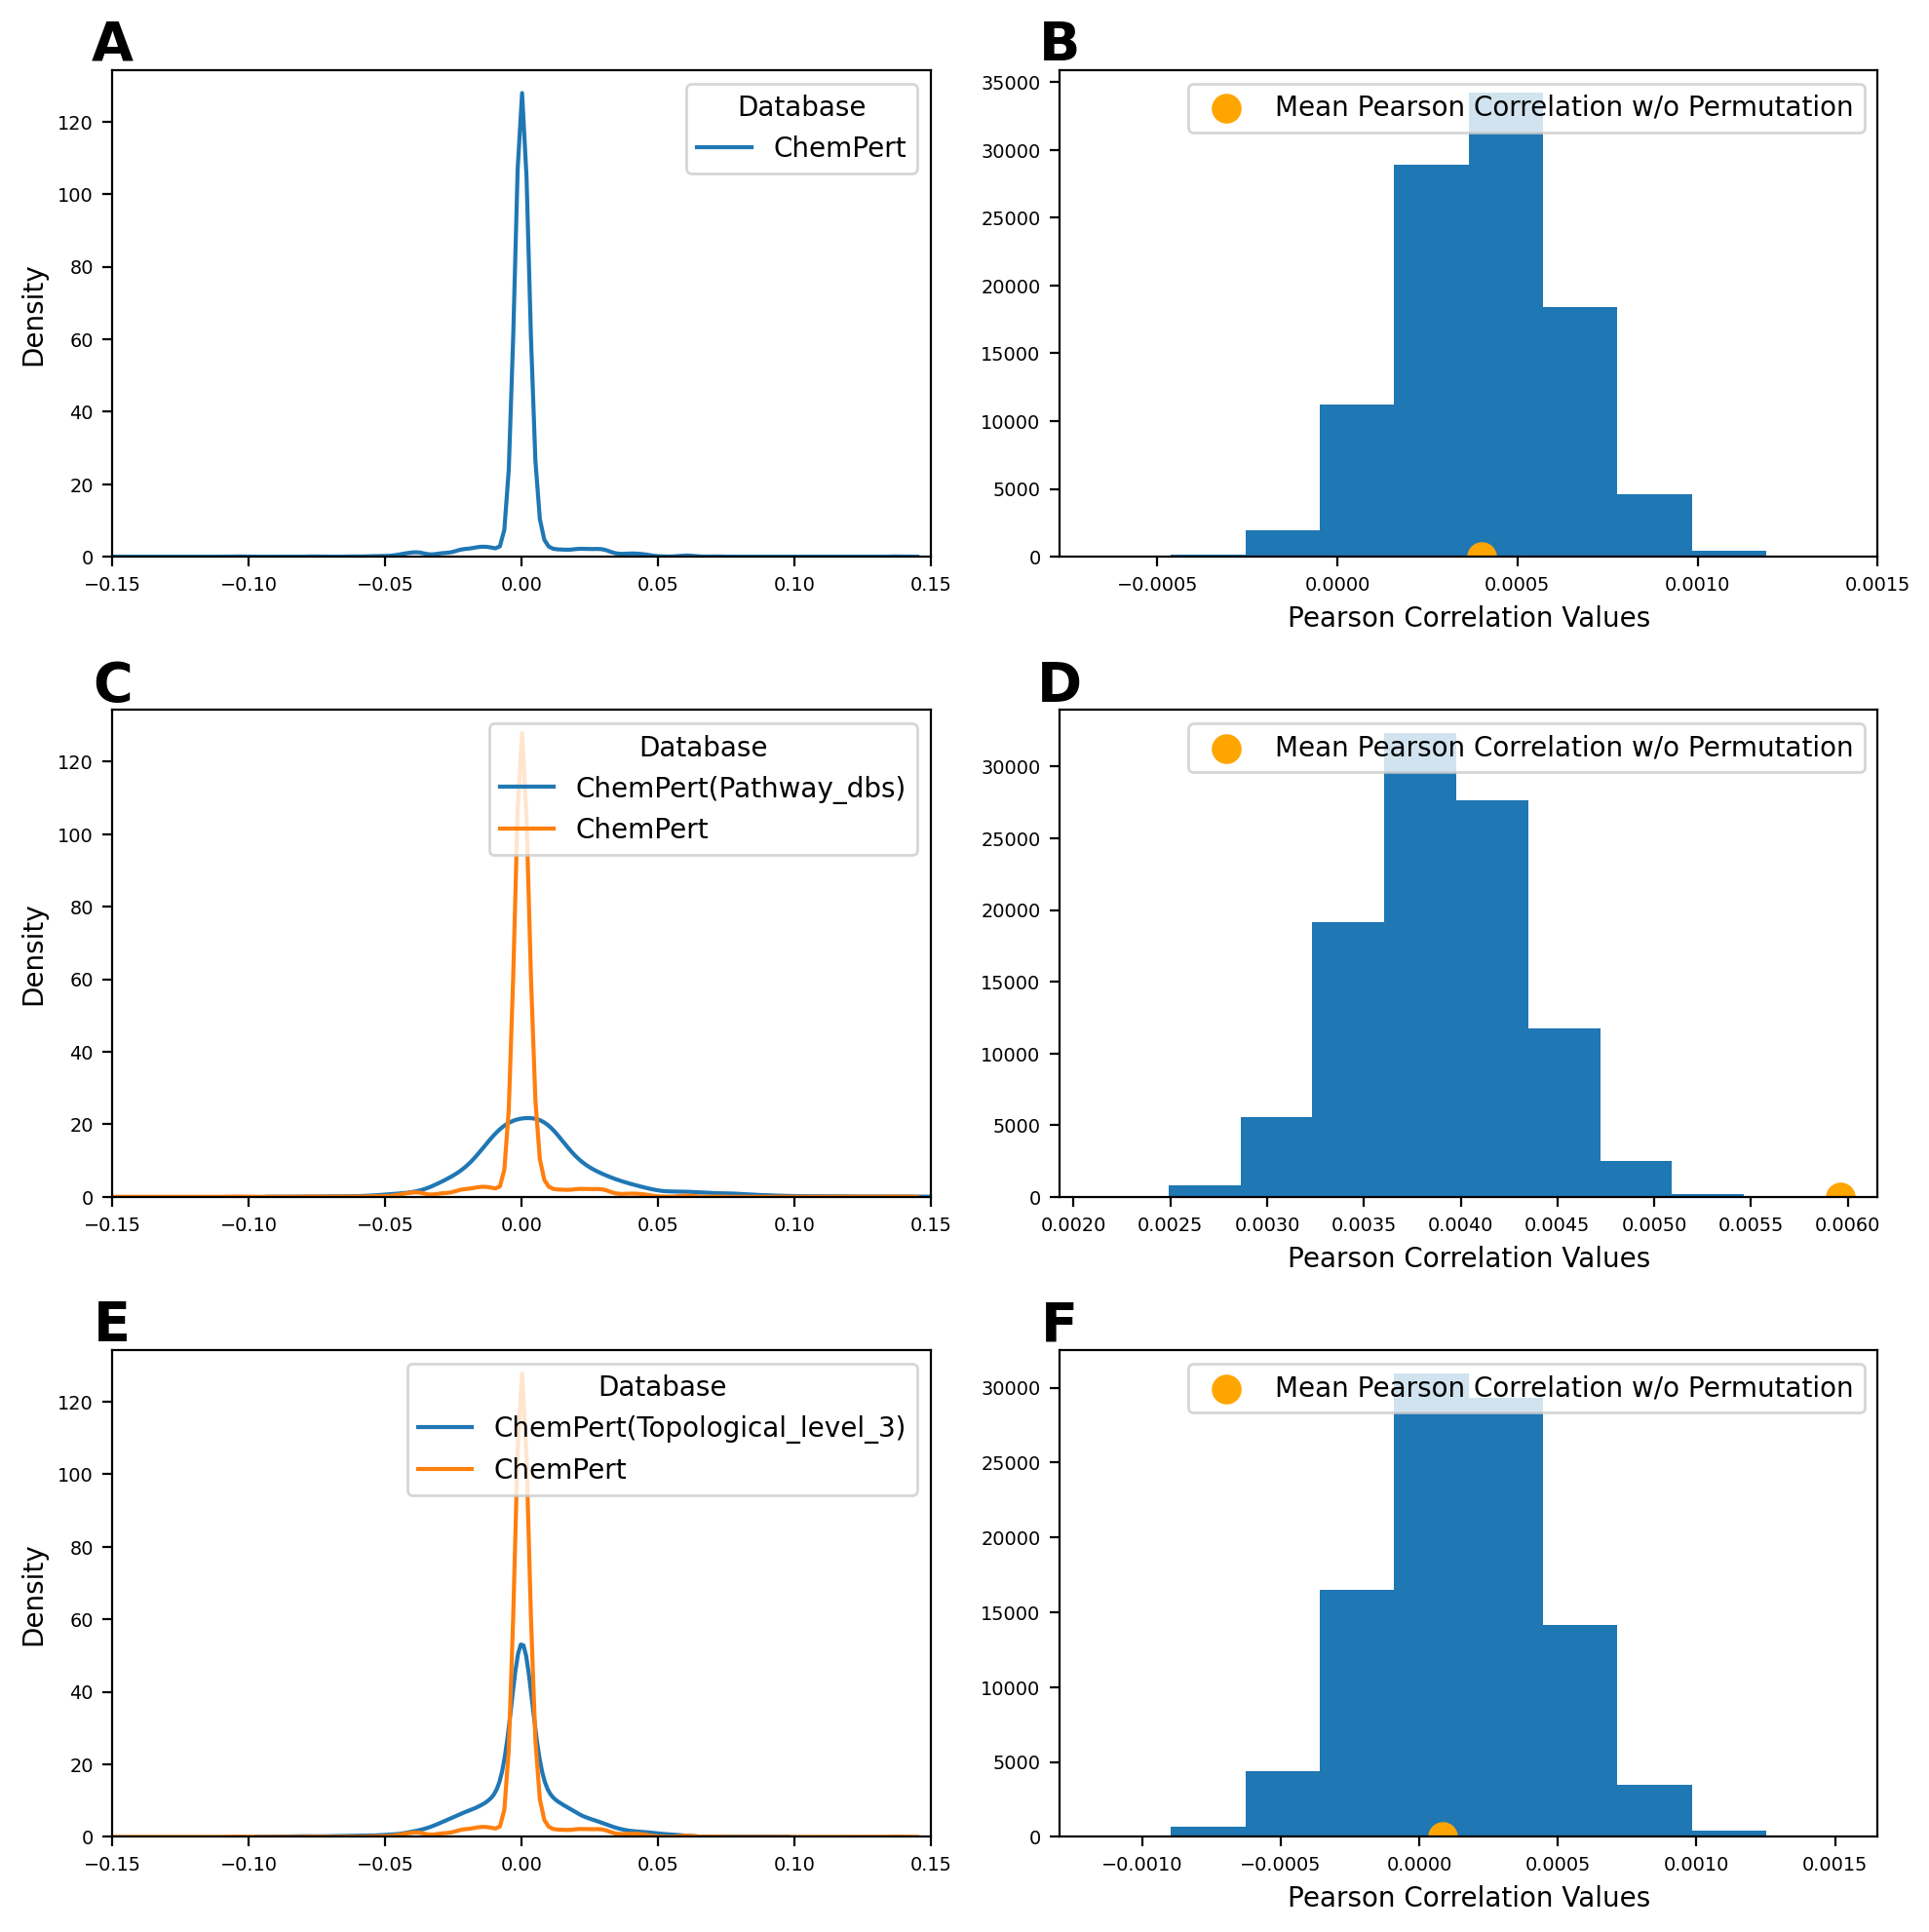

In [16]:
#Set initial variables
current_pearson_corr_df = {}
current_jaccard_corr_df = {}
p_values = []
plt.figure(dpi=200, figsize=([10,10]))

for j,database in enumerate(databases):
    #Set initial variables
    permutation_means = []
    num_compounds = target_df[database].shape[0]
    num_permutations = 100000
  
    #calculate pearson correlation for 100 different permutations
    plt.subplot(len(databases), 2, 2*j+1)
    permutations = [target_df[database].copy().reset_index(drop=True).corrwith(transcript_df[database].copy()
                                                                               .sample(frac=1)
                                                                               .reset_index(drop=True), 
                                              method='pearson', axis =1).values
                     for i in tqdm_notebook(range(num_permutations))]
    permutation_means = [np.sum(p)/num_compounds for p in permutations]

    #Plot pearson correlation scores for the permutations
    sns.distplot(pearson_corr_df[database].values, hist=False, label=database)
    if database != 'ChemPert':
        sns.distplot(pearson_corr_df['ChemPert'].values, hist=False, label='ChemPert')
    plt.xlim([-.15, .15])
    plt.legend(title='Database', loc='upper right')
    plt.text(0, 1.05, string.ascii_uppercase[2*j],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    plt.xticks(fontsize = 'x-small')
    plt.yticks(fontsize = 'x-small')

    #Plot the mean pearson correlation scores for the permutations
    original_mean = np.nansum(pearson_corr_df[database]['pearson_correlation'])/num_compounds
    plt.subplot(len(databases), 2, 2*j+2)
    plt.hist(permutation_means, zorder=0)
    plt.scatter(original_mean, .2, s = 100, \
                label = 'Mean Pearson Correlation w/o Permutation', color = 'orange')
    plt.xlabel('Pearson Correlation Values')
    plt.text(0, 1.05, string.ascii_uppercase[2*j+1],  
        size=20, weight='bold', horizontalalignment='center',
        verticalalignment='center',
        transform = plt.gca().transAxes)
    plt.xticks(fontsize = 'x-small')
    plt.yticks(fontsize = 'x-small')
    plt.legend()


    #Get the permutation test p-value (based on the means)
    p_value = (len([x for x in permutation_means if x >= original_mean])+1)/num_permutations
    p_values.append(p_value)
    
plt.tight_layout()
plt.savefig('../figures/figure_3.png')
plt.show()

In [17]:
#Set initial variables
ks_values = []
stat_df = pd.DataFrame(columns = ['Permutation Test P-value'])

#Pick random permutation test and do the KS test with the original pearson correlation scores
for i,database in enumerate(databases):
#         ks_values.append(stats.ks_2samp(np.squeeze(current_pearson_corr_df[database].values), 
#                                                        np.squeeze(pearson_corr_df[database].values))[1])
    stat_df.loc[database] = p_values[i]
    
stat_df.head(len(database))

,Permutation Test P-value
ChemPert,0.51582
ChemPert(Pathway_dbs),0.00001
ChemPert(Topological_level_3),0.59089


### Permutate pairs and apply Jaccard similarity

In [18]:
from scipy.spatial.distance import jaccard
def jaccard_corr(x,y):
    return 1 - jaccard(x,y)

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

  0%|          | 0/100000 [00:00<?, ?it/s]

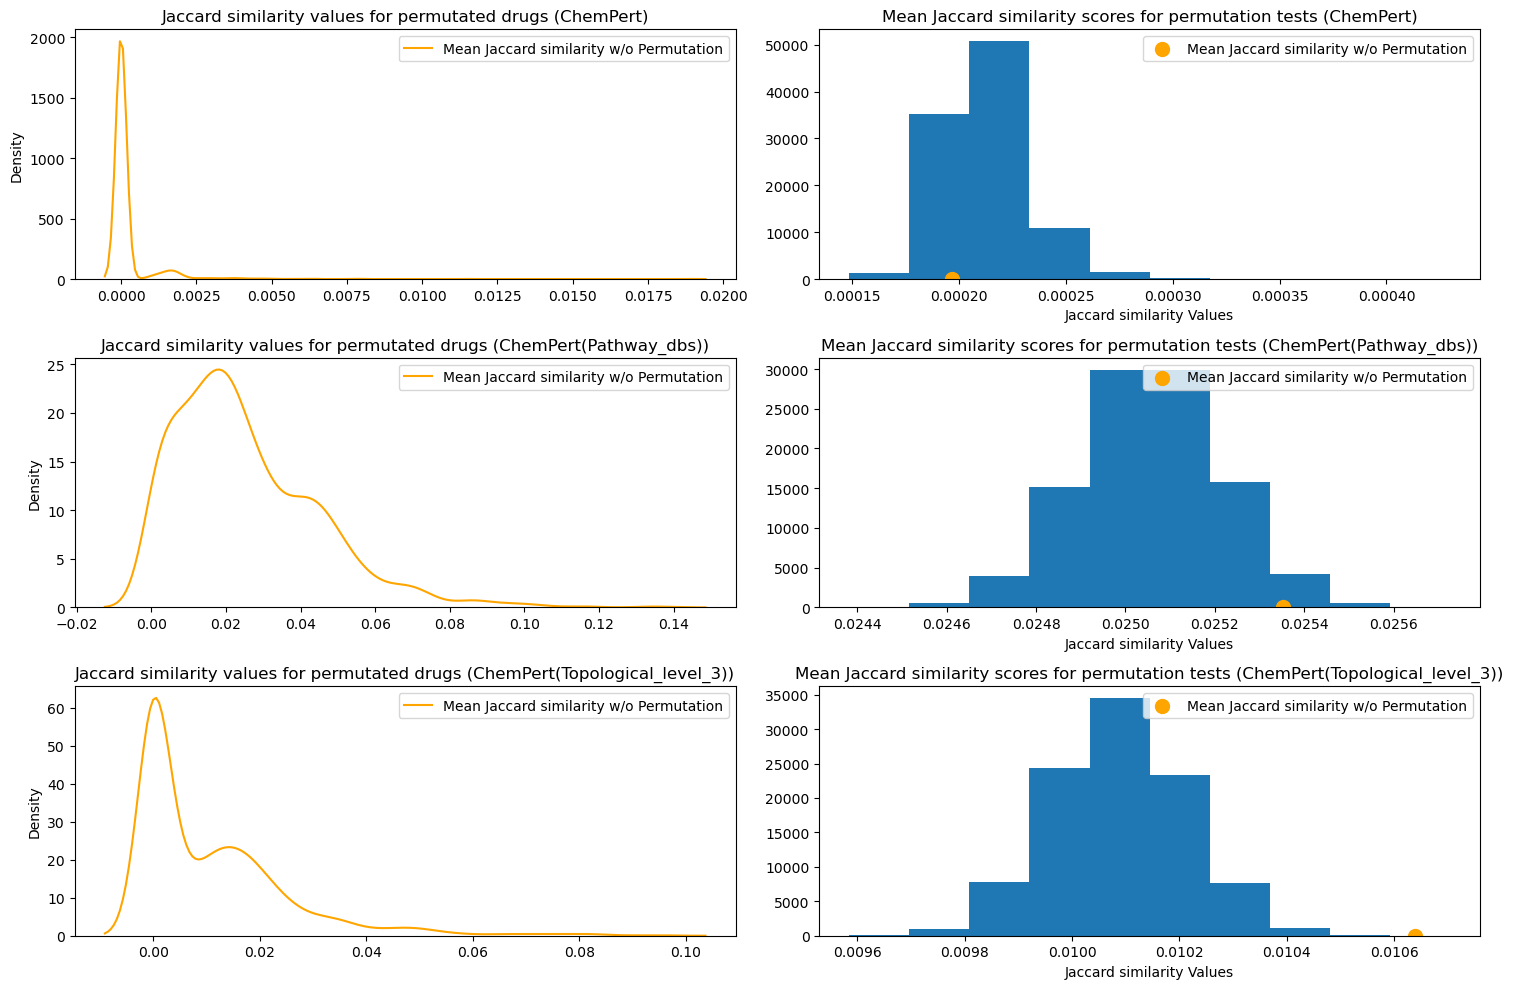

In [19]:
current_jaccard_corr_df = {}
plt.figure().set_size_inches(15,10)
p_values = []

for j,database in enumerate(databases):
    #Set initial variables
    permutation_means = []
    num_compounds = target_df[database].shape[0]
    num_permutations = 100000

    #Get Jaccard similarity scores for 100 different permutations
    plt.subplot(len(databases), 2, 2*j+1)
    permutation_means = [np.sum(target_df[database].copy().reset_index(drop=True)
                                .corrwith(transcript_df[database].copy()
                                .sample(frac=1)
                                .reset_index(drop=True), 
                                          method=jaccard_corr, axis =1))/num_compounds 
                         for i in tqdm_notebook(range(num_permutations))]

    #Plot Jaccard similarity scores for the permutations
    sns.distplot(jaccard_corr_df[database].values, hist=False, color='orange', label = 'Mean Jaccard similarity w/o Permutation')
    plt.legend()
    plt.title("Jaccard similarity values for permutated drugs (" + database + ")")
    plt.legend()

    #Plot the mean Jaccard similarity scores for the permutations
    original_mean = sum(jaccard_corr_df[database]['jaccard_correlation'])/num_compounds
    plt.subplot(len(databases), 2, 2*j+2)
    plt.hist(permutation_means, zorder=0)
    plt.scatter(original_mean,.2, s=100,\
                label = 'Mean Jaccard similarity w/o Permutation', color = 'orange')
    plt.xlabel('Jaccard similarity Values')
    plt.title("Mean Jaccard similarity scores for permutation tests (" + database + ")")
    plt.legend()

    #Get the p-value for the permutation test (based on the means)
    p_value = (len([x for x in permutation_means if x >= original_mean])+1)/num_permutations
    p_values.append(p_value)
    
plt.tight_layout()
plt.show()

In [20]:
#Set initial variables
ks_values = []
stat_df = pd.DataFrame(columns = ['Permutation Test P-value'])

#Pick random permutation test and do the KS test with the original jaccard similarity scores
for i,database in enumerate(databases):
    stat_df.loc[database] = [p_values[i]]
    
stat_df.head(len(databases))

,Permutation Test P-value
ChemPert,0.80413
ChemPert(Pathway_dbs),0.03282
ChemPert(Topological_level_3),0.00005


# Cluster Proteins and Drugs

### Get Protein Correlation scores

In [21]:
def get_pearson_corr_proteins(
    target_matrix: pd.DataFrame,
    transcriptomic_matrix: pd.DataFrame,
):
    """Get Pearson correlation for each drug."""
    correlation_matrix = []
    
    for protein in tqdm(target_matrix.columns):
        target_vector = target_matrix[protein]
        transcriptomic_vector = transcriptomic_matrix[protein]
        corr_val, p_val = pearsonr(target_vector, transcriptomic_vector)
        correlation_matrix.append(
            {
                'protein': protein,
                'pearson_correlation': corr_val
            }
        )
    
    correlation_df = pd.DataFrame(correlation_matrix)
    correlation_df.set_index('protein', inplace=True)
    return correlation_df

100%|█████████████████████████████████████| 4938/4938 [00:00<00:00, 7575.79it/s]


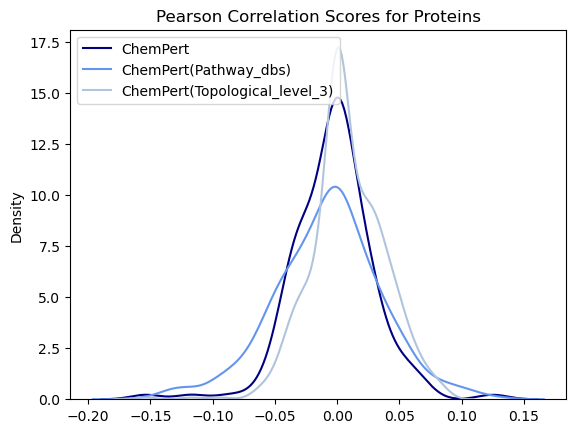

In [22]:
#Set initial variables
protein_correlation_df = {}

#Get protein correlations from each database
for i,database in enumerate(databases):
    protein_correlation_df[database] = get_pearson_corr_proteins(target_df[database], transcript_df[database])
    sns.distplot(protein_correlation_df[database].values, label=database, color=colors[i], hist=False)
    protein_correlation_df[database]['protein_uniprot'] = protein_correlation_df[database].index.values
plt.title('Pearson Correlation Scores for Proteins')
plt.legend()
plt.show()

### Get protein classes

In [23]:
#Get map from HGNC symbols to NCBI genes
map_df= pd.read_csv('../data/Protein_mappings/proteins.tsv', sep='\t', header=None)
map_df = map_df.rename({0: 'NCBI', 2:'HGNC'}, axis=1)
map_df.head()

map_keys = list(map_df['HGNC'])
map_values = list(map_df['NCBI'])
map_dict = {map_keys[i]: map_values[i] for i in range(len(map_keys))}

#Get 1st map to map proteins to NCBI Codes
map_uniprot_df = pd.read_csv('../data/Protein_mappings/proteins_uniprot.tsv', sep='\t', header=None)
map_uniprot_df = map_uniprot_df.rename({0: 'code', 1:'NCBI'}, axis=1)
map_uniprot_df.head()

map_uniprot_keys = list(map_uniprot_df['NCBI'])
map_uniprot_values = list(map_uniprot_df['code'])
map_uniprot_dict = {map_uniprot_keys[i]: map_uniprot_values[i] for i in range(len(map_uniprot_keys))}

#Create function that maps the protein to HGNC symbols
def dict_func(x):
    try:
        result = map_uniprot_dict[map_dict[x]]
    except:
        result = 'None'
    return result

for database in databases:
    #Convert protein codes to uniprot codes
    protein_correlation_df[database]['protein_uniprot'] = protein_correlation_df[database]['protein_uniprot'].map\
                                                            (lambda x: dict_func(x))
    protein_correlation_df[database]['protein_uniprot'] = protein_correlation_df[database]['protein_uniprot'].map\
                                                            (lambda x: x.split(':')[1] if x != 'None' else x)
    print("Number of Unmapped proteins from " + database + ": " + str(list(protein_correlation_df[database]['protein_uniprot'])\
                                                             .count('None')))
    print("Number of proteins from " + database + ": " + str(protein_correlation_df[database].shape[0]))

Number of Unmapped proteins from ChemPert: 76
Number of proteins from ChemPert: 4938
Number of Unmapped proteins from ChemPert(Pathway_dbs): 76
Number of proteins from ChemPert(Pathway_dbs): 4938
Number of Unmapped proteins from ChemPert(Topological_level_3): 76
Number of proteins from ChemPert(Topological_level_3): 4938


### Plot Protein Class Against Correlation Scores

In [24]:
def get_protein_class(uniprot_code):
    """ Get protein class if the protein is an enzyme.
    If the protein is not an enzyme return 0"""
    try:
        return protein_classes.loc[uniprot_code,'EC number'].split('.')[0]
    except:
        return 0
    
def get_protein_mass(uniprot_code):
    """Get the protein mass"""
    try:
        return float(protein_classes.loc[uniprot_code,'Mass'].replace(',',''))
    except:
        return 0

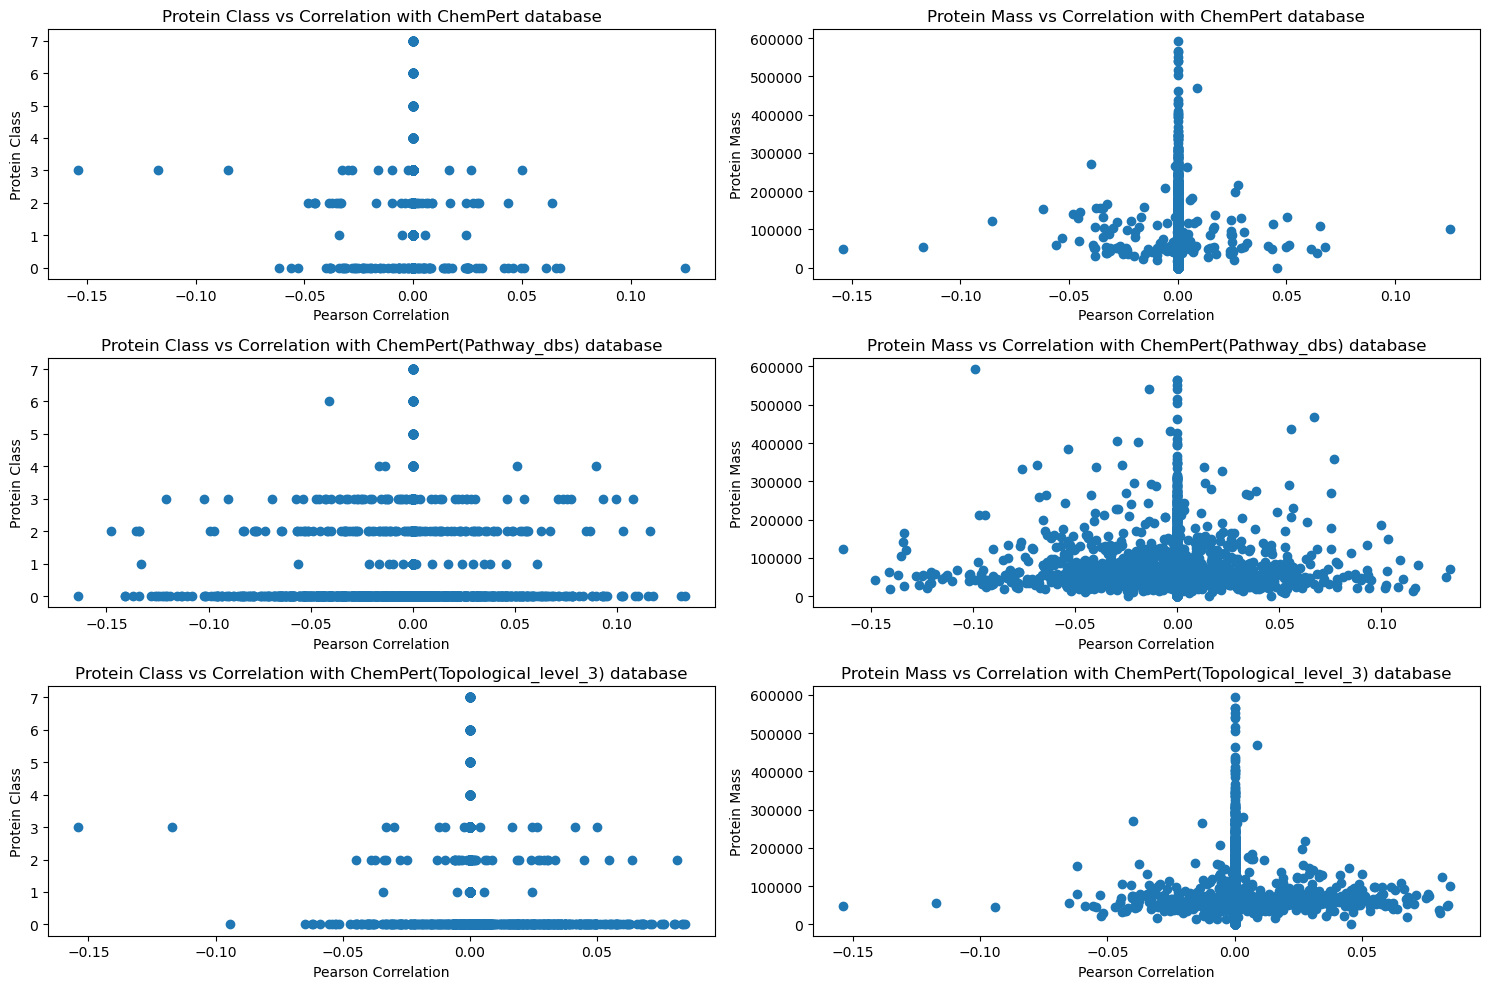

In [25]:
#Set initial variables
protein_classes = pd.read_csv('../data/Protein_classes/protein_classes.csv')
protein_classes = protein_classes.set_index('Entry')
plt.figure().set_size_inches(15,10)

for i,database in enumerate(databases):
    #Add protein mass and class to the data frame
    protein_correlation_df[database]['protein_class'] = protein_correlation_df[database]['protein_uniprot']\
                                                .map(lambda x: get_protein_class(x))
    protein_correlation_df[database]['mass'] = protein_correlation_df[database]['protein_uniprot']\
                                                .map(lambda x: get_protein_mass(x))
    protein_correlation_df[database]['pearson_correlation'] = protein_correlation_df[database]['pearson_correlation']\
                                                    .map(lambda x: x if not pd.isna(x) else 0)
    

    #Plot protein class vs. pearson correlation
    plt.subplot(len(databases), 2, 2*i+1)
    plt.scatter(protein_correlation_df[database]['pearson_correlation'], protein_correlation_df[database]['protein_class'])
    plt.title("Protein Class vs Correlation with " + database + " database")
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Protein Class')

    #Plot protein mass vs. pearson correlation
    plt.subplot(len(databases), 2, 2*i+2)
    plt.scatter(protein_correlation_df[database]['pearson_correlation'], protein_correlation_df[database]['mass'])
    plt.title("Protein Mass vs Correlation with " + database + " database")
    plt.xlabel('Pearson Correlation')
    plt.ylabel('Protein Mass')
    
plt.tight_layout()
plt.show()

### Pubchem Properties vs. Protein Correlation

In [26]:
#Get pubchem codes
pubchem_id = list(pd.read_csv(r'../data/Protein_classes/pubchem_drugs.csv')['Unnamed: 0'])

#Load chemical names data frame
chemical_names = pd.read_csv('../data/ChemPert_data/Information_for_perturbagens_2.csv', sep='@')
chemical_names = chemical_names.set_index("'id'")
chemical_names.head()

#Create chemical names dictionary
chemical_names_dict_keys = list(chemical_names['Chemical_ID'])
chemical_names_dict_values = list(chemical_names['Chemical_Compound'])
chemical_names_dict = {chemical_names_dict_keys[i]:chemical_names_dict_values[i] for i in \
                       range(len(chemical_names_dict_values))}

#Get chemical names
drugs= target_df['ChemPert'].index.values
drug_names = [chemical_names_dict[drug] for drug in drugs]

In [27]:
#Get pubchem properties from all drugs in this dataset
all_drugs_pubchem = pd.read_csv('../data/Protein_classes/all_drugs_pubchem.csv')
all_drugs_pubchem = all_drugs_pubchem.set_index('cid')

pubchem_list = [int(x.split(':')[1]) for x in tqdm_notebook(pubchem_id) if x != 'None']
all_drugs_pubchem = all_drugs_pubchem.reindex(pubchem_list)

  0%|          | 0/2152 [00:00<?, ?it/s]

Pearson Correlation: 0.022307265909900145


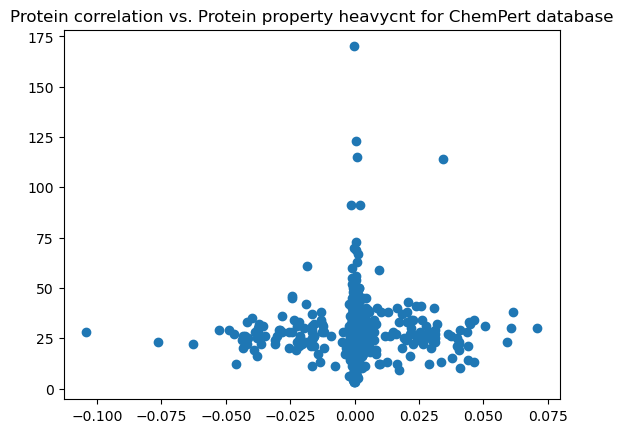

Pearson Correlation: 0.07383871970374031


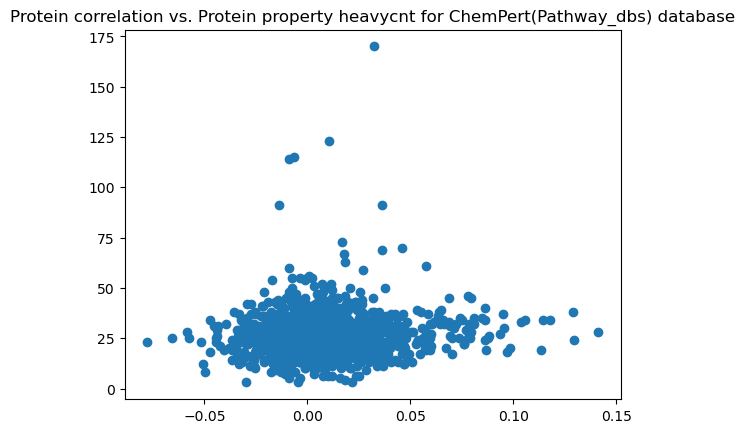

Pearson Correlation: -0.020317862624326024


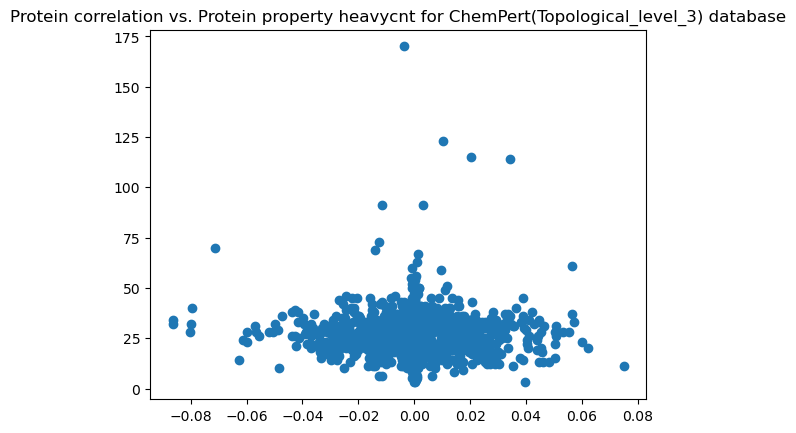

In [28]:
#Set initial variables
pearson_corr_df_filtered = {}
mapped_drugs = [pearson_corr_df['ChemPert'].index.values[i] for i in \
                range(len(pearson_corr_df['ChemPert'].index.values)) if pubchem_id[i] != 'None']
protein_property = 'heavycnt'

#Compare drug properties and correlation scores
for database in databases:
    pearson_corr_df_filtered[database] = pearson_corr_df[database].copy()
    pearson_corr_df_filtered[database] = pearson_corr_df_filtered[database].filter(mapped_drugs, axis = 0)
    print("Pearson Correlation: " + str(pearsonr(pearson_corr_df_filtered[database]['pearson_correlation'],
                                                 all_drugs_pubchem[protein_property])[0]))
    plt.scatter(pearson_corr_df_filtered[database]['pearson_correlation'], all_drugs_pubchem[protein_property])
    plt.title('Protein correlation vs. Protein property ' + protein_property + ' for ' + database + ' database')
    plt.show()

# Look at Drugs with the highest correlation scores

In [29]:
#Set initial variables
high_corr_pubchem_id = {}

#Get pubchem IDs for all drugs
pubchem_id_df = pd.read_csv(r'../data/Protein_classes/pubchem_drugs.csv')
pubchem_id_df.columns = ['pubchem', 'chempert']
pubchem_id_df = pubchem_id_df.set_index('chempert')
pubchem_id_df.head()

#Get pucbchem IDs for drugs with high correlation
for database in databases:
    high_corr_drugs = pearson_corr_df[database].nlargest(100, 'pearson_correlation').index.values
    high_corr_pubchem_id[database] = [pubchem_id_df.loc[drug, 'pubchem'] for drug in high_corr_drugs]

In [30]:
import ast

#Get disease classes that each drug is associated to 
icd_drug_classes = pd.read_csv('../data/Protein_classes/icd_drug_classes.csv')
icd_drug_classes = icd_drug_classes.set_index('drug')
icd_drug_classes = icd_drug_classes.drop('Unnamed: 0', axis=1)
icd_drug_classes = icd_drug_classes['class'].apply(lambda s: list(ast.literal_eval(s)))

icd_drug_classes.keys()
classes = pd.Series(data=icd_drug_classes.values, index=icd_drug_classes.keys())
classes = pd.DataFrame(classes)
classes['class'] = [int(x[0]) if len(x) == 1 else np.nan for x in icd_drug_classes.values]
classes = classes.dropna()
classes = classes.drop([0], axis=1)
classes

,class
drug,
pubchem.compound:15604015,2.0
pubchem.compound:5684,8.0
pubchem.compound:445713,11.0
pubchem.compound:1242,13.0
pubchem.compound:180081,8.0
...,...
pubchem.compound:28693,13.0
pubchem.compound:460612,2.0
pubchem.compound:3677,11.0


In [31]:
test = pd.concat([transcript_df['ChemPert'],classes], axis=1).fillna(np.nan)
test

,AAAS,AADAC,AADACL2,AADAT,AASS,AATF,ABAT,ABCA1,ABCB1,ABCB11,...,ZSCAN4,ZSCAN5A,ZSCAN5B,ZSCAN5DP,ZSCAN9,ZXDA,ZXDB,ZXDC,ZZZ3,class
CID00001,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,-1.0,NaN
CID00002,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,-1.0,NaN
CID00006,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,NaN
CID00007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,NaN
CID00009,0.0,0.0,0.0,0.0,0.0,-1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
pubchem.compound:28693,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0
pubchem.compound:460612,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0
pubchem.compound:3677,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0
pubchem.compound:2162,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.0


Chi-squared p-value for ChemPert database: 0.598085095958538
Chi-squared p-value for ChemPert(Pathway_dbs) database: 3.275807062461121e-05
Chi-squared p-value for ChemPert(Topological_level_3) database: 0.016296694102974896


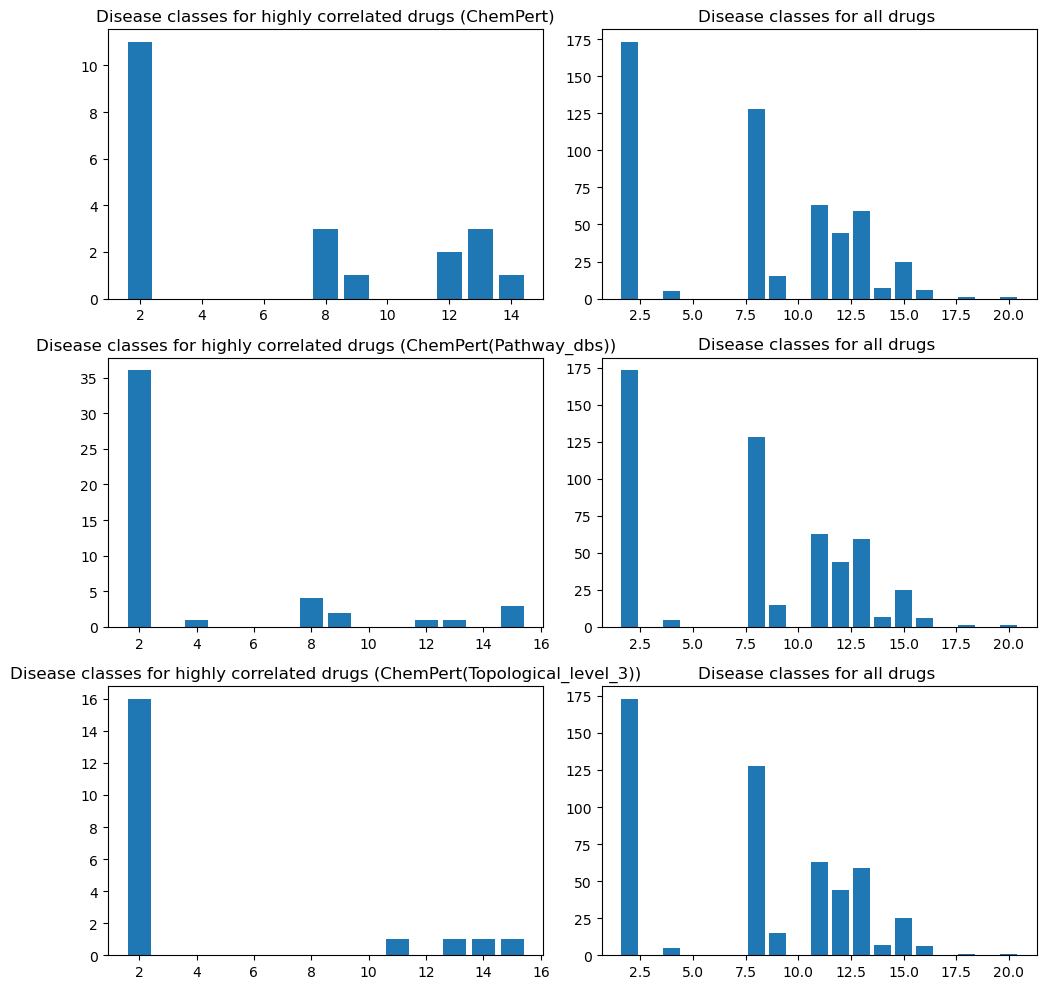

In [32]:
#Set initial variables
all_classes = []
all_counts = []
j = 0

#Get list of all disease classes for all drugs
for drug in icd_drug_classes.index.values:
    all_classes = all_classes + list(icd_drug_classes.loc[drug])
    
#Get number of drugs that are associated to each class
all_unique_classes = np.unique(all_classes, return_counts=True)
all_counts = all_unique_classes[1]

plt.figure(figsize=(10,10))
for k,database in enumerate(databases):
    #Set initial varaibles
    current_classes =[] 
    current_counts = []
    j = 0
    
    #Get list of classes that the highly correlated drugs are associated with
    for drug in high_corr_pubchem_id[database]:
        if drug in icd_drug_classes.index.values:
            current_classes = current_classes + list(icd_drug_classes.loc[drug])
     
    #Get number of highly correlated drugs that are associated with each class
    current_unique_counts = np.unique(current_classes, return_counts=True)
    for i in all_unique_classes[0]:
        if i in np.unique(current_classes, return_counts=True)[0]:
            current_counts.append(current_unique_counts[1][j])
            j += 1
        else:
            current_counts.append(0)
      
    #Get chi squared p-value to determine if the drugs that are highly correlated 
    #come from the same distribution of disease classes as all of the drugs
    test = np.array([current_counts, all_counts])
    print('Chi-squared p-value for ' + database + ' database: ' + str(stats.chi2_contingency(test)[1]))
    
    plt.subplot(len(databases),2,k*2+1)
    plt.bar(current_unique_counts[0], current_unique_counts[1])
    plt.title('Disease classes for highly correlated drugs (' + database + ')')
    
    plt.subplot(len(databases),2,k*2+2)
    plt.bar(all_unique_classes[0], all_unique_classes[1])
    plt.title('Disease classes for all drugs ')

plt.tight_layout()
plt.show()